In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

plt.style.use(['grid', 'notebook'])

In [ ]:
#initiating the class
class SheetPile:
    def __init__(self, properties):

        #initializing the properties
        self.phi = properties['phi'] #soil friction angle in degrees
        self.gamma_unsat = properties['gamma_unsat'] #unsaturated unit weight in kN/m3
        self.mode = properties['mode'] #0 = water table exists, 1 = dry sand, 2 = free cantilever conditions

        if self.mode == 0:
            self.gamma_sat = properties['gamma_sat']
        
        else:
            self.gamma_sat = properties['gamma_unsat'] + 9.81
        
        self.L1 = properties['L1'] #depth from water table to the dredge line
        self.L2 = properties['L2'] 

        #applied load in case of free cantilever
        if self.mode == 2:
            self.P_c = properties['P']
            self.L = properties['L']

        #the intermediate results
        self.ka = None
        self.kp = None
        self.sigma_1_dash = None
        self.sigma_2_dash = None
        self.L3 = None
        self.P = None
        self.zbar = None
        self.sigma_5_dash = None
        self.L4 = None
        self.sigma_4_dash = None
        self.sigma_3_dash = None
        self.L5 = None

    #functions for embedded cantilever sheet piles 
    #func1.1 and 1.2 = earth pressure calc
    #active
    def earth_pressure_active(self):
        phi_rad = self.phi * (np.pi/ 180)
        self.ka = (1-np.sin(phi_rad))/(1+np.sin(phi_rad))
        return self.ka
    
    #passive
    def earth_pressure_passive(self):
        self.kp = 1 / self.ka
        return self.kp
    
    #func2 = sigma1-dash calculation aka the effective stress just above the water table
    def sigma_1_eff(self): #gamma_unsat is the unit weight of soil above the water table, L1 is given
        self.sigma_1_dash = self.gamma_unsat * self.L1 * self.ka
        return self.sigma_1_dash
    
    #func 3 = sigma2-dash calculation aka the effective stress just below the water table but above the dredge line
    def sigma_2_eff(self):
        gamma_eff = self.gamma_sat - 9.810
        self.sigma_2_dash = self.sigma_1_dash + gamma_eff * self.L2 * self.ka
        return self.sigma_2_dash
    
    #func 4 - L3 calculation aka the depth from the dredge line to the active-passive reversal point
    def L3_calc(self):
        gamma_eff = self.gamma_sat - 9.810
        self.L3 = self.sigma_2_dash / (gamma_eff * (self.kp - self.ka))
        return self.L3
    
    #func 5 - P calculation aka calculating the total active pressure above the dredge line (area of ACDEA)
    def P_calc(self):
        self.P = (0.5 * self.L1 * self.sigma_1_dash) + \
                (self.L2 * self.sigma_1_dash) + \
                (0.5 * self.L2 * (self.sigma_2_dash - self.sigma_1_dash)) + \
                (0.5 * self.L3 * self.sigma_2_dash)
        return self.P
    
    #func 6 - zbar calculation aka moment arm of P from E
    def zbar_calc(self):
        z1 = self.L2 + self.L3 + self.L1 / 3
        z2 = self.L3 + self.L2 / 2
        z3 = self.L3 + (1 / 3) * self.L2
        z4 = (2 / 3) * self.L3

        P1 = 0.5 * self.L1 * self.sigma_1_dash
        P2 = self.L2 * self.sigma_1_dash
        P3 = 0.5 * self.L2 * (self.sigma_2_dash - self.sigma_1_dash)
        P4 = 0.5 * self.L3 * self.sigma_2_dash

        self.zbar = (P1 * z1 + P2 * z2 + P3 * z3 + P4 * z4) / (P1 + P2 + P3 + P4)
        return self.zbar
    
    #func 7 - sigma_5_dash calculation
    def sigma_5_eff(self):
        gamma_eff = self.gamma_sat - 9.81
        self.sigma_5_dash = (self.gamma_unsat * self.L1 + gamma_eff * self.L2) * self.kp + \
                        gamma_eff * self.L3 * (self.kp - self.ka)
        return self.sigma_5_dash
    
    #func 8 - calculate the coefficients for the calculation of L4
    def constants_A(self):
        gamma_eff = self.gamma_sat - 9.81
        list_constants = [
            self.sigma_5_dash / (gamma_eff * (self.kp - self.ka)),
            (8 * self.P) / (gamma_eff * (self.kp - self.ka)),
            (6 * self.P * (2 * self.zbar * gamma_eff * (self.kp - self.ka) + self.sigma_5_dash)) / \
            (gamma_eff * (self.kp - self.ka)) ** 2,
            (self.P * (6 * self.zbar * self.sigma_5_dash + 4 * self.P)) / \
            (gamma_eff * (self.kp - self.ka)) ** 2
        ]
        return list_constants
    
    #func 9 - solve for L4
    def calc_L4(self, list_constants):
        coeff = [1, list_constants[0], -1 * list_constants[1], -1 * list_constants[2], -1 * list_constants[3]]
        root = np.roots(coeff)

        for r in root:
            if np.isreal(r) and r > 0:
                self.L4 = np.real(r)
                break
        return self.L4
    
    #func 10 - calculate sigma_4_dash
    def sigma_4_eff(self):
        gamma_eff = self.gamma_sat - 9.81
        self.sigma_4_dash = self.sigma_5_dash + gamma_eff * self.L4 * (self.kp - self.ka)
        return self.sigma_4_dash
    
    #func 11 - calculate sigma_3_dash
    def sigma_3_eff(self):
        gamma_eff = self.gamma_sat - 9.81
        self.sigma_3_dash = self.L4 * (self.kp - self.ka) * gamma_eff
        return self.sigma_3_dash
    
    #func 11 - calculate L5
    def calc_L5(self):
        self.L5 = (self.sigma_3_dash * self.L4 - 2 * self.P) / (self.sigma_3_dash + self.sigma_4_dash)
        return self.L5
    
    #functions for free cantilever sheet pile
    #func1 solve for dredge depth
    def fc_dredgedepth(self):
        a1 = (8 * self.P_c)/(self.gamma_unsat*(self.kp-self.ka))
        a2 = (12 * self.P_c * self.L) / (self.gamma_unsat*(self.kp-self.ka))
        a3 =  np.power(((1/4) * a1), 2)

        coeff = (1, 0,-1*a1, -1 * a2, - 1 * (a3 * a3))
        root = np.roots(coeff)

        for r in root:
            if np.isreal(r) and r>0:
                self.D_fc = np.real(r)
                break

        return self.D_fc
    
    def sigma_5_fc(self):
        self.L5_fc = ((self.gamma_unsat * (self.kp - self.ka) * np.power(self.D_fc, 2)) - 2 * self.P_c) / (2 * self.D_fc * (self.kp - self.ka) * self.gamma_unsat)
        return self.L5_fc
    
    def sigma_3_fc(self):
        self.fcsigma_3 = self.gamma_unsat * self.D_fc * (self.kp - self.ka)
        return self.fcsigma_3
        
    #draw the pressure diagram
    def pressure_draw(self):
        if self.mode != 2: #for embedded cantilever with or without water-table
            self.earth_pressure_active()
            self.earth_pressure_passive()
            self.sigma_1_eff()
            self.sigma_2_eff()
            self.L3_calc()
            self.P_calc()
            self.zbar_calc()
            self.sigma_5_eff()
            constants = self.constants_A()
            self.calc_L4(constants)
            self.sigma_4_eff()
            self.sigma_3_eff()
            self.calc_L5()

            print(f"ka = {self.ka}")
            print(f"kp = {self.kp}")
            print(f"sigma_1_dash = {self.sigma_1_dash} kPa/m")
            print(f"sigma_2_dash = {self.sigma_2_dash} kPa/m")
            print(f"L3 = {self.L3} m")
            print(f"P = {self.P} kN/m")
            print(f"zbar = {self.zbar} m")
            print(f"sigma_5_dash = {self.sigma_5_dash} kPa/m")
            print(f"L4 = {self.L4} m")
            print(f"sigma_4_dash = {self.sigma_4_dash} kPa/m")
            print(f"sigma_3_dash = {self.sigma_3_dash} kPa/m")
            print(f"L5 = {self.L5} m")

            #stress at L5:
            self.stress_l5 = ((self.sigma_3_dash) * (self.L4 - self.L5)) / self.L4

            depths = [0, -1 * self.L1, -1 * (self.L1 + self.L2), -1 * (self.L1 + self.L2 + self.L3),
                    -1 * (self.L1 + self.L2 + self.L3 + self.L4 - self.L5), -1 * (self.L1 + self.L2 + self.L3 + self.L4),
                    -1 * (self.L1 + self.L2 + self.L3 + self.L4)]
            stresses = [0, self.sigma_1_dash, self.sigma_2_dash, 0, -1 * self.stress_l5, self.sigma_4_dash, 0]

            depths2 = [depths[4], depths[6], depths[6]]
            stresses2 = [stresses[4], -1* self.sigma_3_dash, 0]


            plt.plot(stresses, depths, marker = 'o', linewidth = 2.0, color = 'green', label = 'Net pressure')

            if self.mode == 0:
                plt.plot([-1 * self.sigma_4_dash, self.sigma_4_dash], [-1*(self.L1), -1*(self.L1)], linewidth = 2.0, color = 'blue', linestyle = '--', label = 'GWT')
            plt.plot(stresses2, depths2, linestyle = ':', color = 'green', marker = 'o')
            plt.plot([0, 0], [0, -1 * (self.L1 + self.L2 + self.L3 + self.L4)], linewidth = 3.0, color = 'black', label = 'Sheet pile')
            plt.plot([-1 * self.sigma_4_dash, self.sigma_4_dash], [-1*(self.L1 + self.L2), -1*(self.L1 + self.L2)], linewidth = 3.0, color = 'brown', label = 'Dredge level')
            plt.xlabel('Stresses (kPa/m)')
            plt.ylabel('Depth (m)')
            plt.title('Pressure Distribution')
            plt.legend()
            plt.show()

        else: #special case = free cantilever
            self.earth_pressure_active()
            self.earth_pressure_passive()
            self.fc_dredgedepth()
            self.sigma_5_fc()
            self.sigma_3_fc()

            print(f'ka = {self.ka}')
            print(f'kp = {self.kp}')
            print(f'D = {self.D_fc} m')
            print(f'L5 = {self.L5_fc}')
            print(f'sigma3 = sigma4 = {self.fcsigma_3} kPa/m')

            self.stress_l5 = ((self.fcsigma_3) * (self.D_fc - self.L5_fc)) / self.D_fc

            depths = [-1 * self.L, -1 * (self.L + (self.D_fc - self.L5_fc)), -1 * (self.L + self.D_fc), -1 * (self.L + self.D_fc)]
            stresses = [0, -1 * self.stress_l5, self.fcsigma_3, 0]

            depths2 = [-1 * (self.L + (self.D_fc - self.L5_fc)), -1 * (self.L + self.D_fc), -1 * (self.L + self.D_fc)]
            stresses2 = [-1 * self.stress_l5, -1 * self.fcsigma_3, 0]

            #plotting the stresses
            plt.plot(stresses, depths, marker = 'o', linewidth = 2.0, color = 'green', label = 'Net pressure')
            plt.plot(stresses2, depths2, linestyle = ':', color = 'green', marker = 'o')
            plt.plot([0, 0], [0, -1 * (self.L + self.D_fc)], linewidth = 3.0, color = 'black', label = 'Sheet pile')
            plt.plot([-1 * self.fcsigma_3, self.fcsigma_3], [-1*(self.L), -1*(self.L)], linewidth = 3.0, color = 'brown', label = 'Dredge level')
            plt.xlabel('Net earth pressure (kPa/m)')
            plt.ylabel('Depth (m)')
            plt.title('Pressure Distribution')
            plt.legend()
            plt.show()

    def complete_calc(self):
        self.pressure_draw()

        if self.mode == 0 or self.mode == 1:
            self.dredge_depth_calc = (self.L3 + self.L4)
            self.dredge_depth_eff = round(1.3 * (self.L3 + self.L4), 1)
            print(f'Calculated dredge depth = {self.dredge_depth_calc} m')
            print(f'Effective dredge depth = {self.dredge_depth_eff} m')

        else:
            self.dredge_depth_calc = self.D_fc
            self.dredge_depth_eff = round(1.3 * self.dredge_depth_calc, 1)
            print(f'Calculated dredge depth = {self.dredge_depth_calc} m')
            print(f'Effective dredge depth = {self.dredge_depth_eff} m')


ka = 0.3072585245224685
kp = 3.2545883032998626
sigma_1_dash = 9.770821079814498 kPa/m
sigma_2_dash = 18.546124540176194 kPa/m
L3 = 0.6609787407152236 m
P = 58.37553653165722 kN/m
zbar = 2.2302585185611443 m
sigma_5_dash = 214.99307452735587 kPa/m
L4 = 4.741700023980793 m
sigma_4_dash = 348.0384415867367 kPa/m
sigma_3_dash = 133.04536705938085 kPa/m
L5 = 1.0686498648946665 m


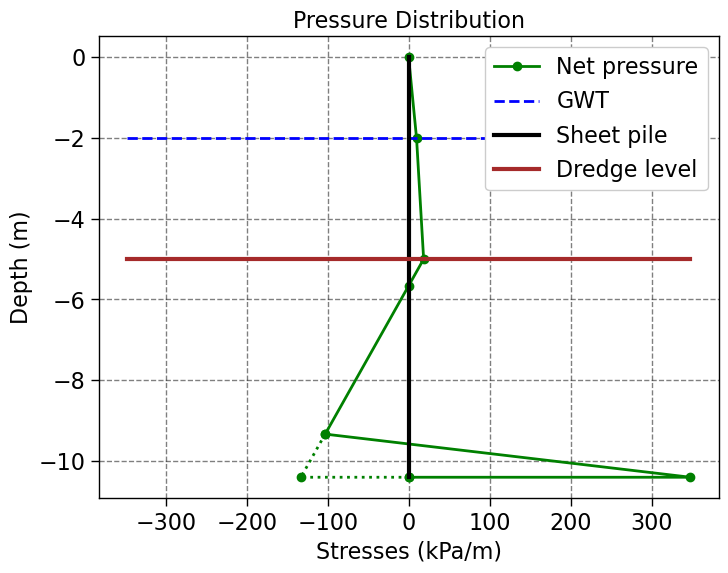

Calculated dredge depth = 5.402678764696017 m
Effective dredge depth = 7.0 m


In [3]:
#example 1: water table present
# Define properties
properties = {
    'phi': 32,  
    'gamma_unsat': 15.9,  
    'gamma_sat': 19.33,  
    'L1': 2,  
    'L2': 3,  
    'mode': 0,
}

# Create SheetPile object
sheet_pile = SheetPile(properties)

# Perform calculations and plot
sheet_pile.complete_calc()

ka = 0.3072585245224685
kp = 3.2545883032998626
sigma_1_dash = 9.770821079814498 kPa/m
sigma_2_dash = 24.427052699536247 kPa/m
L3 = 0.5212489737913294 m
P = 67.43391982503061 kN/m
zbar = 2.014165982527553 m
sigma_5_dash = 283.16682281187536 kPa/m
L4 = 4.007143611343837 m
sigma_4_dash = 470.95176453934073 kPa/m
sigma_3_dash = 187.78494172746534 kPa/m
L5 = 0.9375724534918755 m


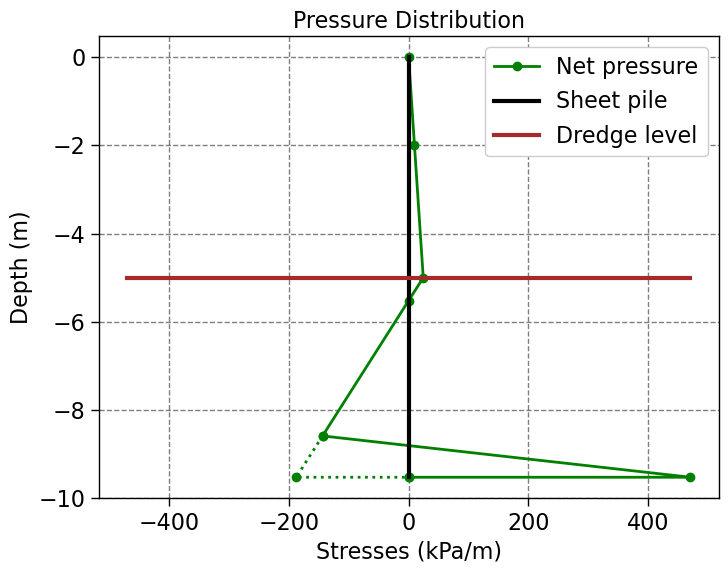

Calculated dredge depth = 4.528392585135166 m
Effective dredge depth = 5.9 m


In [4]:
#example 2: no water table
# Define properties
properties = {
    'phi': 32,  
    'gamma_unsat': 15.9,  
    'gamma_sat': 19.33,  
    'L1': 2,  
    'L2': 3,  
    'mode': 1
}

# Create SheetPile object
sheet_pile = SheetPile(properties)

# Perform calculations and plot
sheet_pile.complete_calc()

ka = 0.3072585245224685
kp = 3.2545883032998626
D = 6.628530149644078 m
L5 = 2.9923384416472154
sigma3 = sigma4 = 310.6297823631593 kPa/m


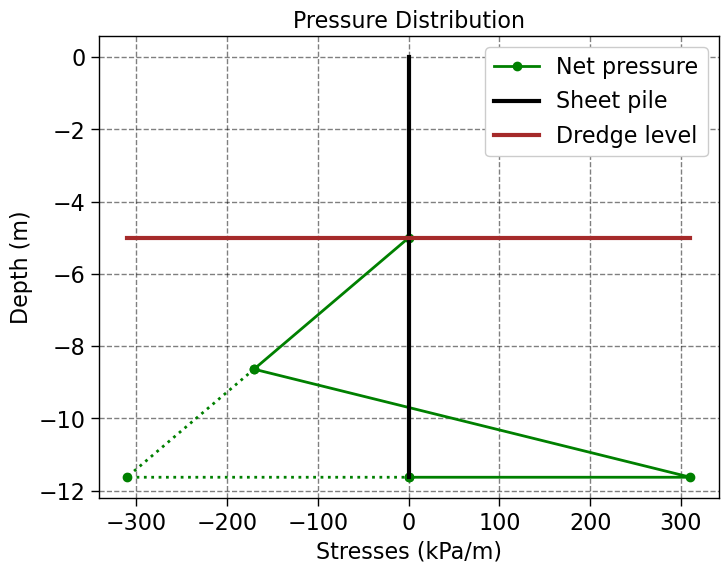

Calculated dredge depth = 6.628530149644078 m
Effective dredge depth = 8.6 m


In [5]:
#example 3: free cantilever case
# Define properties
properties = {
    'phi': 32,  
    'gamma_unsat': 15.9,  
    'L1': 2,  
    'L2': 3,  
    'mode': 2,
    'P' : 100,
    'L' : 5
    
}

# Create SheetPile object
sheet_pile = SheetPile(properties)

# Perform calculations and plot
sheet_pile.complete_calc()